# 2-d Hard Disk Gas

Here we will investigate the first application of the Metropolis algorithm 


[Equation of State Calculations by Fast Computing Machines](https://aip.scitation.org/doi/10.1063/1.1699114) J. Chem. Phys. 21, 1087 (1953). 

This is somewhat simpler than the probabilistic one we just looked at because the "hard disk" just means the walker's probability is 0% if the proposed step overlaps with another disk, and 100% otherwise. 

In [1]:
%matplotlib widget

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
'''
Disks: this will hold N disks in a 2-dimensional plane.
It has a function "update" to perform a MC trial step. 
If "overlaps" is satisfied (i.e. the disks at the new position
do not overlap with other disks) then the trials are accepted. 

This is performed in a vectorized format. 
'''
class Disks:

    def __init__(self, N, d0, alpha):
        self.N = N
        self.d0 = d0
        self.alpha = alpha
        self.pos = np.zeros((N,2))
        self.apply_pbcs()

    '''
    apply_pbcs: this applies periodic boundary conditions
    '''
    def apply_pbcs(self):
        self.pos = self.pos % 1.0            
            
    '''
    overlaps: check for overlaps between the disks
    '''
    def overlaps(self, pos1, pos2):        
        delta = pos1 - pos2
        delta = np.where( np.abs(delta) > 0.5, delta * (1-1/np.abs(delta)), delta)        
        return np.linalg.norm(self.pos, axis=1) < self.d0

    '''
    update : make a MC trial position. Check where it would overlap with
    another disk. If there are no overlaps, use the trial as the new position. 
    '''
    def update(self):
        pos_try = self.pos + self.alpha * np.random.uniform(-1,1, size=self.pos.shape)
        pos_try_overlaps = self.overlaps( pos_try, self.pos)        
        self.pos[:,0] = np.where( pos_try_overlaps, self.pos[:,0], pos_try[:,0] )
        self.pos[:,1] = np.where( pos_try_overlaps, self.pos[:,1], pos_try[:,1] )
        self.apply_pbcs()        
        return np.sum( pos_try_overlaps )
    
    
'''
System: keeps track of the disks,
runs the MC steps, and keeps a histogram
of the disk-to-disk distances as they change
over time. This is used to derive the equation
of state. 
'''    
class System:

    def __init__(self, nu=0, K=1.5, rows=16, cols=16, N_bins=64):
        # Initialize all of the constants
        d = 1.0 / float(cols)        
        self.d0 = d * (1 - 2**(nu-8.0))        # Center-to-center distance between circles
        self.K = K                             # Kinetic energy
        self.alpha = d - self.d0               # Leftover space between circles
        self.N=rows*cols                       # Total number of circles
        self.rows=rows                         # Number of rows
        self.cols=cols                         #    and columns
        self.N_bins = N_bins                   # Number of bins for the histogram
        self.DeltaA2 = (self.K**2 - 1) * np.pi * self.d0**2 / float(self.N_bins)
        self.disks = Disks(self.N, self.d0, self.alpha)
        dx = d
        dy = d * np.sqrt(3.0) / 2.0        
        i = np.arange(rows)
        j = np.arange(cols)
        iv,jv = np.meshgrid(i,j)
        self.iv = iv
        self.jv = jv
        self.N_array = np.arange(self.N)
        # Keep a list of the combinations for later use
        self.i0, self.i1 = np.meshgrid(self.N_array, self.N_array)
        # Initialize to positions staggered by a half a column for each row
        self.disks.pos[:,0] = (iv * dx + jv % 2 * dx / 2).reshape( self.N )
        self.disks.pos[:,1] = (jv * dy).reshape( self.N ) 
        self.rvals = np.zeros(0)
        self.fitvals = np.zeros(0)

    def update(self):
        accepts = self.disks.update()
        self.pair_histogram()

    def pair_histogram(self):           
        xv = self.disks.pos[:,0].flatten()
        yv = self.disks.pos[:,1].flatten()
        dx = xv.flatten()[self.i0] - xv.flatten()[self.i1]
        dy = yv.flatten()[self.i0] - yv.flatten()[self.i1]        
        delta_ij = dx**2 + dy**2
        fitval = (delta_ij - self.d0**2) * np.pi / self.DeltaA2
        self.rvals = np.concatenate( (self.rvals, delta_ij.flatten()) )
        self.fitvals = np.concatenate( (self.fitvals, fitval.flatten()) )

## Initialize the simulation

Also show the initial positions. 

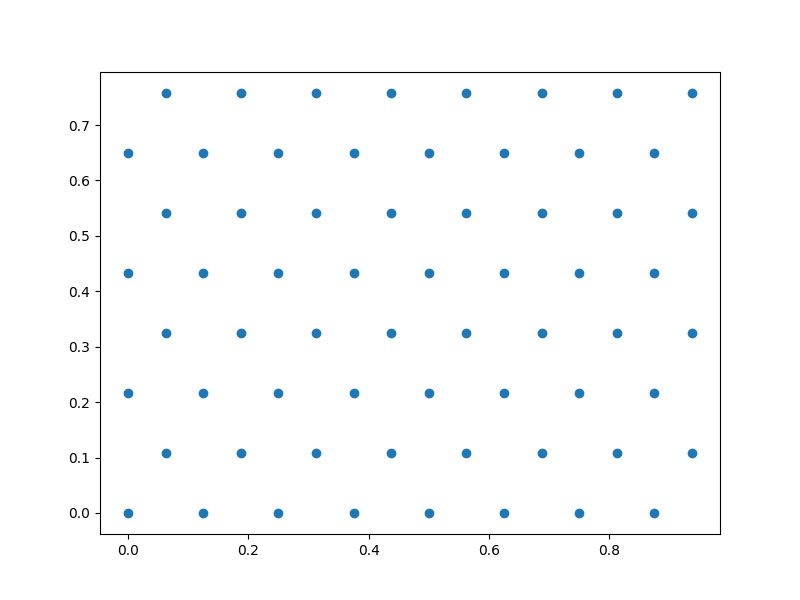

In [37]:
nu = 5
system = System(nu, rows=8, cols=8)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(system.disks.pos[:,0], system.disks.pos[:,1])



In [38]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

## Make a histogram of the $r$ values

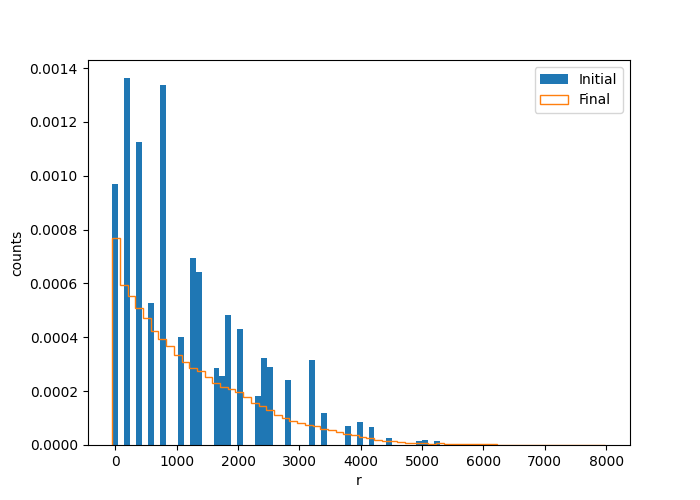

(array([9.69773980e-04, 0.00000000e+00, 1.36170336e-03, 0.00000000e+00,
       1.12554078e-03, 0.00000000e+00, 5.27597243e-04, 0.00000000e+00,
       1.33657968e-03, 0.00000000e+00, 0.00000000e+00, 4.01978852e-04,
       0.00000000e+00, 6.93413519e-04, 6.43166163e-04, 0.00000000e+00,
       0.00000000e+00, 2.86409932e-04, 2.56261518e-04, 4.82374622e-04,
       0.00000000e+00, 4.32127266e-04, 0.00000000e+00, 0.00000000e+00,
       1.80890483e-04, 3.21583081e-04, 2.91434667e-04, 0.00000000e+00,
       0.00000000e+00, 2.41187311e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.16558346e-04, 0.00000000e+00, 1.20593655e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.03462990e-05,
       0.00000000e+00, 8.54205060e-05, 0.00000000e+00, 6.53215634e-05,
       0.00000000e+00, 0.00000000e+00, 2.51236782e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50742069e-05,
       2.00989426e-05, 0.00000000e+00, 1.50742069e-05, 0.00000000e+00,
     

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Radial distribution function of initial values
system.pair_histogram()
hh_initial_r = ax.hist(system.fitvals.flatten(), bins=system.N_bins, density=True, label="Initial") #plt.hist(system.fitvals.flatten(), bins=system.N_bins, density=True, fill=False, alpha=0.5)

# Run Metropolis-Hastings for a while
for i in range(500):
    system.update()

# Final radial distribution function
hh_final_r = ax.hist(system.fitvals.flatten(), bins=system.N_bins, histtype="step", density=True, label="Final") # plt.hist(system.fitvals.flatten(), bins=system.N_bins, density=True, fill=False, alpha=0.5)
#ax.stairs(*hh_initial_r)

ax.set_xlabel("r")
ax.set_ylabel("counts")
ax.legend()
fig.show()

## Make an animator with a newly initialized system

In [7]:
system2 = System(nu, rows=16, cols=16)

## Make an animator

In [8]:
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, system):
        self.system = system
        self.stream = self.data_stream()

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=50, frames=300,
                                          init_func=self.setup_plot, blit=False)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        x, y = next(self.stream).T
        
        # Calculate the radius of the disks in points
        # Using this: https://stackoverflow.com/questions/48172928/scale-matplotlib-pyplot-axes-scatter-markersize-by-x-scale/48174228#48174228
        s = ((self.ax.get_window_extent().width  * (self.system.d0/2) * 100./self.fig.dpi) ** 2)
        self.scat = self.ax.scatter(x, y, s=s, facecolors='none', edgecolors='r' )
        self.ax.axis([0, 1, 0, 1])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        
        while True:
            self.system.update()
            yield np.c_ [self.system.disks.pos[:,0], self.system.disks.pos[:,1]]

    def update(self, i):
        """Update the scatter plot."""
        data = next(self.stream)

        # Set x and y data...
        self.scat.set_offsets(data[:, :2])
        # Set sizes...
        #self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
        #self.scat.set_array(data[:, 3])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,


## Run and animate

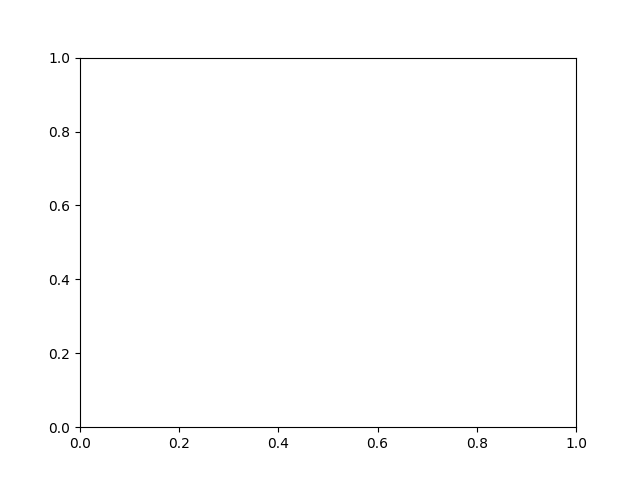

In [9]:

a = AnimatedScatter(system=system2)